<a href="https://colab.research.google.com/github/utkarshminhas/violence-detection-fyp/blob/main/notebooks/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set dataset paths

In [9]:
original_train_dir = '/content/drive/Shareddrives/Final Year Project/Datasets/RWF-2000/train'
original_val_dir = '/content/drive/Shareddrives/Final Year Project/Datasets/RWF-2000/val'

processed_train_dir = '/content/drive/Shareddrives/Datasets/RWF-2000/processed_train'
processed_val_dir = '/content/drive/Shareddrives/Datasets/RWF-2000/processed_val'

# raw_rwf_dir = '/content/drive/Shareddrives/Final Year Project/Datasets/Mini-RWF-2000'
# processed_rwf_dir = '/content/drive/Shareddrives/Final Year Project/Datasets/Processed'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Export to frames

In [5]:
import os
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import numpy as np
import tensorflow as tf

In [6]:
def generate_base_folders(original_dir, processed_dir):
    if not os.path.exists(processed_dir):
        os.makedirs(processed_dir)

    categories = os.listdir(original_dir)
    
    for category in categories:
        cur_op_dir = os.path.join(processed_dir, category)
        if not os.path.exists(cur_op_dir):
            os.makedirs(cur_op_dir)

def convert_to_frames(original_dir, processed_dir):
    categories = os.listdir(original_dir)

    for category in tqdm(categories):
        videos = os.listdir(os.path.join(original_dir, category))

        for video in tqdm(videos, position=0, leave=True):
            generate_frames(category, video, original_dir, processed_dir)


def get_mask(frame):
    fgbg = cv2.createBackgroundSubtractorMOG2(
           varThreshold=15,
       detectShadows=True
    )

    mog_mask = fgbg.apply(frame)
    median_blur_mask = cv2.medianBlur(mog_mask, 5)
    bilateral_filter_mask = cv2.bilateralFilter(median_blur_mask, 9, 75, 75)
    gaussian_blur_mask = cv2.GaussianBlur(bilateral_filter_mask, (13, 13), 5)

    return gaussian_blur_mask


def generate_frames(category, video, original_dir, processed_dir):
    base_video_name, _ = os.path.splitext(video)
    video_ip_path = os.path.join(original_dir, category, video)
    video_op_dir_path = os.path.join(processed_dir, category, base_video_name)

    if not os.path.exists(video_op_dir_path):
        os.makedirs(video_op_dir_path)

    cap = cv2.VideoCapture(video_ip_path)
    framerate = int(cap.get(5))

    capture_frequency = 5

    while True:
        frame_number = int(cap.get(1))
        success, frame = cap.read()

        if not success or frame is None:
            break

        masked_frame = get_mask(frame)

        if frame_number % capture_frequency == 1:
            exporting_frame_number = int(frame_number / capture_frequency)
            frame_path = os.path.join(video_op_dir_path, "frame_{0:0=3d}.jpg".format(exporting_frame_number))
            cv2.imwrite(frame_path, masked_frame)

        k = cv2.waitKey(30)

        if k == 27 or k == ord('q'):
            break

    cap.release()


In [10]:
generate_base_folders(original_train_dir, processed_train_dir)
generate_base_folders(original_val_dir, processed_val_dir)

In [11]:
with tf.device('/device:GPU:0'):
    convert_to_frames(original_train_dir, processed_train_dir)

100%|██████████| 2/2 [2:42:26<00:00, 4873.25s/it]


In [ ]:
with tf.device('/device:GPU:0'):
    convert_to_frames(original_val_dir, processed_val_dir)

100%|██████████| 2/2 [02:08<00:00, 64.00s/it]


# Preprocessing

In [ ]:
# lalalal

# Model

## Some global variables

In [ ]:
image_size = (128, 128)

label_to_int = {
    'Fight': 1,
    'NonFight': 0
}

batch_size = 2

## Training and validation generator

In [ ]:
def preprocess(img):
    img = cv2.resize(img, image_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0

    temp = img
    img = []
    for r in range(len(temp)):
        cur_row = []
        for c in range(len(temp[r])):
            cur_row.append([temp[r][c]])
        img.append(cur_row)
    img = np.array(img)

    return img


def get_data(batch_size, processed_dir):
    data = []
    batch = []

    categories = os.listdir(processed_dir)

    for category in categories:
        videos = os.listdir(os.path.join(processed_dir, category))

        for video in videos:
            video_folder_path = os.path.join(processed_dir, category, video)
            batch.append([video_folder_path, label_to_int.get(category)])

            # If batch size is not a multiple of total number of videos, it will not return it since the if condition will never be satisfied
            if len(batch) == batch_size:
                data.append(batch)
                batch = []

    return data


def data_generator(data):
    for batch in data:
        x_set = []
        y_set = []

        for video, category in batch:
            current_video = []

            frames = os.listdir(video)
            for frame in frames:
                frame_path = os.path.join(video, frame)
                img = cv2.imread(frame_path)
                img = preprocess(img)

                current_video.append(img)

            x_set.append(current_video)
            y_set.append([category])

        x_set = np.array(x_set)
        y_set = np.array(y_set)

        yield (x_set, y_set)

# **DO NOT BATCH THE VALIDATION DATA**

In [ ]:
train_data = get_data(batch_size, processed_train_dir)
val_data = get_data(1, processed_val_dir)

# Model

## Imports

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 16.2MB/s 


In [ ]:
from tensorflow.keras import layers
import numpy as np
from keras.layers import TimeDistributed, Conv2D, Dense, MaxPooling2D, \
Flatten, LSTM, Dropout, BatchNormalization
from keras import models
import itertools

import keras
from keras import optimizers
import tensorflow_addons as tfa

## Architecture

In [ ]:
input_shape = (30, image_size[0], image_size[1], 1)
num_epochs = 5

In [ ]:
model = models.Sequential(
    [
        TimeDistributed(
            Conv2D(64, (3, 3), activation=tf.nn.relu), 
            input_shape=input_shape
        ),
        TimeDistributed(MaxPooling2D((2, 2), strides=(1, 1))),
        TimeDistributed(Conv2D(128, (4, 4), activation=tf.nn.relu)),
        TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))),
        TimeDistributed(Conv2D(256, (4, 4), activation=tf.nn.relu)),
        TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))),
        TimeDistributed(Flatten()),
        Dropout(0.5),
        LSTM(256, return_sequences=False, dropout=0.5, input_shape=input_shape),
        Dense(1, activation=tf.nn.sigmoid)
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, 30, 126, 126, 64)  640       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 30, 125, 125, 64)  0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 30, 122, 122, 128) 131200    
_________________________________________________________________
time_distributed_24 (TimeDis (None, 30, 61, 61, 128)   0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 30, 58, 58, 256)   524544    
_________________________________________________________________
time_distributed_26 (TimeDis (None, 30, 29, 29, 256)   0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, 30, 215296)       

In [ ]:
gennifer_engineering_trainee = data_generator(train_data)
gennifer_engineering_vallee = data_generator(val_data)

# gennifer_engineering_trainee = itertools.cycle(gennifer_engineering_trainee)
# gennifer_engineering_vallee = itertools.cycle(gennifer_engineering_vallee)

In [ ]:
print('Training Data')
X, y = next(gennifer_engineering_trainee)
print(len(train_data))
print(X.shape, y.shape)

print('Validation Data')
X, y = next(gennifer_engineering_vallee)
print(len(val_data))
print(X.shape, y.shape)

Training Data
YEET 1
20
(2, 30, 128, 128, 1) (2, 1)
Validation Data
YEET 2
10
(2, 30, 128, 128, 1) (2, 1)


In [ ]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()
model_path = 'cnn_lstm_model.h5'

callbacks_list = [
    # tqdm_callback,
    # keras.callbacks.EarlyStopping(monitor=['acc'], patience=3),
    # keras.callbacks.ModelCheckpoint(
    #     filepath=model_path,
    #     monitor='val_loss',
    #     save_best_only=True
    # ),
    # keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss",
    #     factor=0.1,
    #     patience=3
    # )
]

optimizer=optimizers.RMSprop(lr=0.06)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

In [ ]:
with tf.device('/device:GPU:0'):
    history = model.fit(
        gennifer_engineering_trainee,
        steps_per_epoch=4,
        validation_data=gennifer_engineering_vallee,
        validation_steps=2,
        validation_batch_size=batch_size,
        epochs=num_epochs,
        callbacks=callbacks_list,
        batch_size=batch_size
    )

Epoch 1/5
4/4 [==============================] - 15s 4s/step - loss: 0.3137 - acc: 1.0000 - val_loss: 24.3856 - val_acc: 0.0000e+00
Epoch 2/5
4/4 [==============================] - 13s 4s/step - loss: 2.7377e-11 - acc: 1.0000 - val_loss: 24.3856 - val_acc: 0.0000e+00
Epoch 3/5
4/4 [==============================] - 13s 4s/step - loss: 4.5794 - acc: 0.7333 - val_loss: 1.6051e-04 - val_acc: 1.0000
Epoch 4/5
4/4 [==============================] - 13s 4s/step - loss: 1.1281e-04 - acc: 1.0000 - val_loss: 4.3722 - val_acc: 0.5000
Epoch 5/5
4/4 [==============================] - 11s 4s/step - loss: 1.0792e-04 - acc: 1.0000 - val_loss: 8.7526 - val_acc: 0.0000e+00


```
total_number_of_videos = batch_size * (steps_per_epoch * epochs)

number_of_batches = total_number_of_videos / batch_size
```

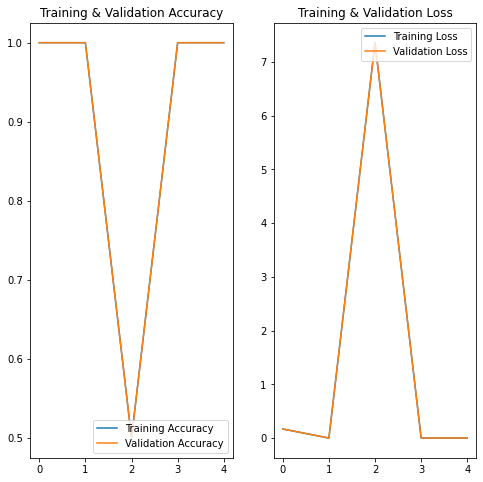

In [ ]:
acc = history.history['acc']
loss = history.history['loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, acc, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, loss, label='Validation Loss')

plt.legend(loc='upper right')
plt.title('Training & Validation Loss')
plt.show()